Please fill out the information of your group!

| <p style="text-align: center;">First Name</p> | <p style="text-align: center;">Family Name</p> | Matr.-No. |
|-----------------------------------------|-----------------------------------------| --- |
| <p style="text-align: left">*Daniil*</p>     | <p style="text-align: left">*Krechko*</p>     | *k12149099* |
| <p style="text-align: left">*Azat*</p> | <p style="text-align: left">*Vakhitov*</p> | *k12148222* |



<h2 style="text-align: center">344.105/6/7 UE: Natural Language Processing (WS2023/24)</h2>
<h1 style="color:rgb(0,120,170)">Assignment 2</h1>
<h2 style="color:rgb(0,120,170)">Getting to Know Word Embedding!</h2>

<b>Terms of Use</b><br>
This  material is prepared for educational purposes at the Johannes Kepler University (JKU) Linz, and is exclusively provided to the registered students of the mentioned course at JKU. It is strictly forbidden to distribute the current file, the contents of the assignment, and its solution. The use or reproduction of this manuscript is only allowed for educational purposes in non-profit organizations, while in this case, the explicit prior acceptance of the author(s) is required.

**Authors:** Shah Nawaz, Shahed Masoudian<br>


<h2>Table of contents</h2>
<ol>
    <a href="#section-general-guidelines"><li style="font-size:large;font-weight:bold">General Guidelines</li></a>
    <a href="#section-taskA"><li style="font-size:large;font-weight:bold">Task A: Words Similarity and Nearest Neighbors (15 points)</li></a>
    <a href="#section-taskB"><li style="font-size:large;font-weight:bold">Task B: Document Classification with Word Embedding (15 points)</li></a>
    <a href="#section-taskC"><li style="font-size:large;font-weight:bold">Task C: Classification with sent2vec Document Embeddings (2 extra point)</li></a>
    <a href="#section-references"><li style="font-size:large;font-weight:bold">References</li></a>
    
</ol>

<a name="section-general-guidelines"></a><h2 style="color:rgb(0,120,170)">General Guidelines</h2>

### Assignment objective
The aim of this assignment is to get familiarized with using word embedding (WE) models in practice. The assignment in total has **30 points**; it also offers **2 extra points** which can cover any missing point.

This Notebook encompasses all aspects of the assignment, namely the descriptions of tasks as well as your solutions and reports. Feel free to add any required cell for solutions. The cells can contain code, reports, charts, tables, or any other material, required for the assignment. Feel free to provide the solutions in an interactive and visual way! 

Please discuss any unclear point in the assignment in the provided forum in MOODLE. It is also encouraged to provide answers to your peer's questions. However when submitting a post, keep in mind to avoid providing solutions. Please let the tutor(s) know shall you find any error or unclarity in the assignment.


### Libraries & Dataset

The assignment should be implemented with recent versions of `Python` (>3.7). Any standard Python library can be used, so far that the library is free and can be simply installed using `pip` or `conda`. Examples of potentially useful libraries are `scikit-learn`, `numpy`, `scipy`, `gensim`, `nltk`, `spaCy`, and `AllenNLP`. Use the latest stable version of each library.

To conduct the experiments, we use a subset of the `HumSet` dataset [1] (https://blog.thedeep.io/humset/). `HumSet` is created by the DEEP (https://www.thedeep.io) project – an open source platform which aims to facilitate processing of textual data for international humanitarian response organizations. The platform enables the classification of text excerpts, extracted from news and reports into a set of domain specific classes. The provided dataset contains the classes (labels) referring to the humanitarian sectors like agriculture, health, and protection. The dataset contains an overall number of 17,301 data points. 

Download the dataset from the Moodle page of the course.

the provided zip file consists of the following files:
- `thedeep.subset.train.txt`: Train set in csv format with three fields: sentence_id, text, and label.
- `thedeep.subset.validation.txt`: Validation set in csv format with three fields: sentence_id, text, and label.
- `thedeep.subset.test.txt`: Test set in csv format with three fields: sentence_id, text, and label.
- `thedeep.subset.label.txt`: Captions of the labels.
- `thedeep.ToU.txt`: Terms of use of the dataset.

[1] HumSet: Dataset of Multilingual Information Extraction and Classification for Humanitarian Crises Response
*Selim Fekih, Nicolo' Tamagnone, Benjamin Minixhofer, Ranjan Shrestha, Ximena Contla, Ewan Oglethorpe and Navid Rekabsaz.* 
In Findings of the 2022 Conference on Empirical Methods in Natural Language Processing (Findings of EMNLP), December 2022.


## Style 

- Please provide evidence at each state by giving print of the results, provide tables, graphs to further improve the quality of your report


### Submission

Each group should submit the following two files:

- One Jupyter Notebook file (`.ipynb`), containing all the code, results, visualizations, etc. **In the submitted Notebook, all the results and visualizations should already be present, and can be observed simply by loading the Notebook in a browser.** The Notebook must be self-contained, meaning that (if necessary) one can run all the cells from top to bottom without any error. Do not forget to put in your names and student numbers in the first cell of the Notebook. 
- The HTML file (`.html`) achieved from exporting the Jupyter Notebook to HTML (Download As HTML).

You do not need to include the data files in the submission.


In [230]:
from gensim.models import KeyedVectors
import pandas as pd
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from IPython.display import display
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import random


In [231]:
PLOTS_SHOW = False

In [ ]:
def full_vocabluary(data):
    all_tokens = [token for doc in data['Text'] for token in doc]

    token_counts = Counter(all_tokens)

    vocab = dict(token_counts)
    return vocab

def remove_stop_words(text):
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

def preprocessing(data):
    
    pattern_2 = r'^"|"$'
    data['Text'] = data['Text'].apply(lambda x: re.sub(pattern_2, '', x))
    
    pattern_3 = r'\s+'
    data['Text'] = data['Text'].apply(lambda x: re.sub(pattern_3, ' ', x))
    
    written_date_pattern = r'\b(?:\d{1,2}(?:st|nd|rd|th)?\s*)?(?:January|February|March|April|May|June|July|August|September|October|November|December)\s*(?:\d{1,2}(?:st|nd|rd|th)?)?\s*(?:\d{4})?\b'
    data['Text'] = data['Text'].apply(lambda x: re.sub(written_date_pattern, '|date| ', x))
    
    percent_pattern = r'\b\d+(?:\s*(?:percent|per\s*cent|%))\b'
    number_pattern = r'\b(?:\d{1,3}(?:[\.,\s]?\d{3})*(?:[\.,]?\d+)?(?:\s*(?:hundred|thousand|million|billion|trillion|k|K|m|M))?|\d+(?:\.\d+)?(?:\s*(?:kg|g|lbs|cm|m|km|ft|in))?)\b'
    percent_patter_0 = r'.*%'
    
    data['Text'] = data['Text'].apply(lambda x: re.sub(percent_pattern, '|num| ', x))
    data['Text'] = data['Text'].apply(lambda x: re.sub(number_pattern, '|num| ', x))
    data['Text'] = data['Text'].apply(lambda x: re.sub(percent_patter_0, '', x))
    
    # Remove marks
    marks_pattern = r'[^\w\s|]'
    data['Text'] = data['Text'].apply(lambda x: re.sub(marks_pattern, ' ', x))
    
    # Convert text to lowercase
    data['Text'] = data['Text'].apply(lambda x: x.lower())
    data['Text'] = data['Text'].apply(remove_stop_words)
    
    # Remove extra whitespace
    data['Text'] = data['Text'].apply(lambda x: re.sub(pattern_3, ' ', x))
    
    # Tokenize and lemmatize
    words = data['Text'].apply(word_tokenize)
    tagged_words = words.apply(pos_tag)
    data['Text'] = tagged_words.apply(lemmatize)
    
    # Replace |num| and |date| back to <num> and <date>
    data['Text'] = data['Text'].apply(lambda tokens: [token.replace('|num|', '<num>').replace('|date|', '<date>') for token in tokens])
    
    return data

def get_wordnet_pos(tag):
    if tag.startswith('NN'):
        return 'n'  # noun
    elif tag.startswith('VB'):
        return 'v'  # verb
    elif tag.startswith('JJ'):
        return 'a'  # adjective
    elif tag.startswith('RB'):
        return 'r'  # adverb
    else:
        return None

def lemmatize(tagged_sentence):
    lemmatized_words = []
    for word, tag in tagged_sentence:
        wordnet_pos = get_wordnet_pos(tag)
    
        if wordnet_pos is None:
            wordnet_pos = 'n'
    
        lemmatized_word = lemmatizer.lemmatize(word, wordnet_pos)
    
        lemmatized_words.append(lemmatized_word)
    return lemmatized_words


def token_statistics(vocab):
    filtered_vocab_1 = {token: count for token, count in vocab.items() if token not in {'<num>', '<date>'}}
    
    counts = list(filtered_vocab_1.values())
    mean_1 = np.mean(counts)
    max_count_1 = np.max(counts)
    min_count_1 = np.min(counts)
    std_dev_1 = np.std(counts)

    return mean_1, max_count_1, min_count_1, std_dev_1

def filter_vocab(vocab, min_freq):
    filtered_vocab = {token: count for token, count in vocab.items() if count >= min_freq}
    return filtered_vocab


def replace_with_oov(data, vocab):
    return [[token if token in vocab else '<OOV>' for token in doc] for doc in data['Text']]

def replace_with_oov_avoid(data, vocab):
    return [[token if token in vocab else token for token in doc] for doc in data['Text']]

def token_statistics_after(vocab_filtered):
    filtered_vocab_2 = {token: count for token, count in vocab_filtered.items() if token not in {'<num>', '<date>'}}
    
    counts = list(filtered_vocab_2.values())  
    mean_2 = np.mean(counts)
    max_count_2 = np.max(counts)
    min_count_2 = np.min(counts)
    std_dev_2 = np.std(counts)

    return mean_2, max_count_2, min_count_2, std_dev_2

def calculate_document_frequencies(data, word_to_index):
    df = np.zeros(vocab_size, dtype=int)
    for doc in data:
        unique_terms = set(doc)
        for term in unique_terms:
            if term in word_to_index:
                index = word_to_index[term]
                df[index] += 1
    return df

def compute_tfidf_vectors(data, word_to_index, df, N):
    idf = np.log(N / (df + 1))

    vectors = []
    for doc in data:
        vector = np.zeros(vocab_size)
        term_counts = Counter(doc)
        for term, count in term_counts.items():
            if term in word_to_index:
                index = word_to_index[term]
                tf = count 
                vector[index] = tf * idf[index]
        vectors.append(vector)
    return vectors

#Sparsity rate
def calculate_sparsity(vectors):
    total_elements = 0
    zero_elements = 0
    for vector in vectors:
        total_elements += len(vector)
        zero_elements += np.count_nonzero(vector == 0)
    sparsity_rate = (zero_elements / total_elements) * 100
    return sparsity_rate

#Nearest neighbours
def calculate_nearest_neighbours(source_vector, target_vectors, k, cosine: bool, dot: bool):

    for word in model.index_to_key:  
        target_vector = model[word]
        
        if cosine:
            return sorted([(word, cosine_similarity(source_vector, model[word])) for word in model.index_to_key], 
                      key=lambda x: x[1], reverse=True)[:k]
        elif dot:
            return sorted([(word, np.dot(source_vector, model[word])) for word in model.index_to_key], 
                      key=lambda x: x[1], reverse=True)[:k]
        else:
            return "Please choose a similarity metric"
        
def analyze_word_contributions_by_category(data, category_column, text_column):
    word_category_counts = {}
    category_totals = {}
    for _, row in data.iterrows():
        category = row[category_column]
        words = row[text_column]
        if category not in word_category_counts:
            word_category_counts[category] = Counter()
        word_category_counts[category].update(words)
        
        if category not in category_totals:
            category_totals[category] = 0
        category_totals[category] += len(words)

    word_contributions = {}
    for category, counter in word_category_counts.items():
        total = category_totals[category]
        word_contributions[category] = {word: count / total for word, count in counter.items()}

    return word_contributions 

def plot_word_contributions(word_contributions, category, top_n=10):
    words, contributions = zip(*sorted(word_contributions[category].items(), key=lambda item: item[1], reverse=True)[:top_n])
    plt.figure(figsize=(10, 6))
    plt.barh(words, contributions, color='skyblue')
    plt.xlabel('Word Contribution')
    plt.title(f'Top {top_n} Word Contributions in Category: {category}')
    plt.gca().invert_yaxis()
    plt.show()

def cosine_similarity(x, y):
    return np.dot(x, y) / (np.linalg.norm(x) * np.linalg.norm(y))

def plot_similarity(word, nearest_neighbors, metric):
    neighbors, similarities = zip(*nearest_neighbors)  
    plt.figure(figsize=(10, 6))
    plt.barh(neighbors, similarities, color="skyblue")
    plt.xlabel(f"{metric} Similarity")
    plt.ylabel("Nearest Neighbors")
    plt.title(f"{metric} Similarity for Word: '{word}'")
    plt.gca().invert_yaxis() 
    plt.show()

# Calculate nearest neighbors
def calculate_nearest_neighbours(source_word, model, k=10, cosine=True, dot=False):
    source_vector = model[source_word]
    if cosine:
        return sorted(
            [(word, cosine_similarity(source_vector, model[word])) for word in model.index_to_key],
            key=lambda x: x[1],
            reverse=True,
        )[:k]
    elif dot:
        return sorted(
            [(word, np.dot(source_vector, model[word])) for word in model.index_to_key],
            key=lambda x: x[1],
            reverse=True,
        )[:k]

<a name="section-taskA"></a><h2 style="color:rgb(0,120,170)">Task A: Words Similarity and Nearest Neighbors (15 points)</h2>


**Loading a word embedding (WE) model (1 points).** Download a pre-trained word embedding model such as word2vec (https://code.google.com/archive/p/word2vec/) or GloVe (https://nlp.stanford.edu/projects/glove/). You can load the downloaded vectors into arrays, or use libraries such as `gensim` to download and process the vectors. 

**Calculating word-to-word similarities (4 points).** Select <ins>5 arbitrary words</ins> from 5 different topics like objects, science disciplines, verbs, adjectives, animals, etc. Let us refer to these words as *source words*. For each source word, calculate its cosine similarities to <ins>6 target words</ins>. The target words of each source word are also selected by you and should cover various levels of semantic relations – according to your linguistic judgement – to the source word, namely from highly-related to not related at all. Organize the target words in tables, such that the target words of each source word are sorted from the highest to the lowest relevance (according to your judgement). Consider the following points:

- **Implementation (2/4 points):** Implement cosine similarity as a function that takes two vectors and returns the similarity score. Implement cosine by yourself and do NOT use the provided functionalities of any library.
- **Reporting and observations (2/4 points):** Report the calculated similarities side by side with your word-to-word semantic relevance judgements in tables. Compare the results and report your observations.  

**Calculating nearest neighbors (10 points).** For the 5 source words, retrieve the $k=10$ nearest neighbors using the word embedding model, namely the words with the highest similarities to the source word. Consider the following points: 
    
- **Overall implementation (3/10 points):** your implemented function takes a source vector, a set of target vectors, and the $k$ parameter, and returns the $k$ nearest neighbors and their similarity scores. Implement nearest neighbor calculation by yourself and do NOT use the provided functionalities of any library.
- **Similarity metrics (2/10 points):** execute the calculation of nearest neighbors according to <ins>two similarity metrics</ins> namely cosine and dot product.
- **Efficiency (3/10 points):** your nearest neighbor functions should provide an *efficient* calculation of nearest neighbors. An inefficient way (which should be avoided!) would be looping over the set of vectors in the word embedding model, and one by one calculating the cosine/dot product similarity of the source vector to each of the target vectors. As a hint for an efficient way, consider that in `numpy` (and other libraries), calculating the dot product of a vector to a matrix is much faster than the dot products of the vector to each vector of the matrix.
- **Reporting and observations (2/10 points):** report the results in tables, which enable comparing between the outputs of the two similarity metrics. Which similarity metric would you prefer? Report your observations.

</div>

In [233]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4') 

stop_words = {
    'the', 'a', 'and', 'to', 'be', 'in', 'that', 'of', 'for', 'on', 'with', 'at', 'by', 'an', 'this',
    'it', 'is', 'was', 'from', 'or', 'but', 'are', 'we', 'can', 'you', 'all', 'have', 'which',
    'there', 'their', 'they', 'who', 'about', 'were', 'had', 'has', 'will', 'my', 'your', 'more', 'if',
    'do', 'does', 'theirs', 'how', 'all', 'any', 'some', 'than', 'then', 'been', 'being',
    'i', 'me', 'us', 'he', 'she', 'him', 'her', 'ours', 'yours', 'ourselves', 'yourself', 'yourselves', 
    'himself', 'herself', 'itself', 'ours', 'those', 'such', 'same', 'so', 'up', 'down', 'where', 
    'when', 'out', 'just', 'over', 'after', 'before', 'once', 'during', 'also', 'because', 'now', 
    'off', 'here', 'one', 'each', 'both', 'either', 'every', 'other', 'again', 'between', 'few', 
    'own', 'against', 'into', 'under', 'above', 'upon', 'among', 'together', 'while', 'nor', 'could', 
    'would', 'should', 'might', 'must', 'very', 'without', 'within', 'through', 'around', 'towards', 
    'onto', 'yet', 'ever', 'always', 'often', 'almost', 'even', 'especially', 'mostly'
}

lemmatizer = WordNetLemmatizer()


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\azatv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\azatv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\azatv\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\azatv\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\azatv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\azatv\AppData\Roaming\nltk_dat

In [234]:
test = pd.read_csv(r"C:\Users\azatv\Jupyter\JupyterProjects\NLP\nlp2024_25_data\nlp2023_24_data\thedeep.subset.test.txt", sep=",", header=None, names=['ID', 'Text', 'Label'], quoting=1, encoding='utf-8')

test = test.drop('ID', axis=1)

test = preprocessing(test)

print("Test Data:")
display(test.head())


Test Data:


,Text,Label
0,"[decrease, mam, child, admission, <num>, <date...",8
1,"[<num>, fear, ebola, lead, attack, health, wor...",9
2,"[wheat, staple, food, most, afghan, comprise, ...",3
3,"[receive, serious, allegation, two, lna, fight...",9
4,"[somali, <num>, <num>, woredas, hotspot, <num>...",8


In [235]:
group_per_label = dict()
labels = np.sort(test["Label"].unique())
label_counts = test["Label"].value_counts()
for label in labels:
    group_per_label[label] = []

for idx, row in test.iterrows():
    label = row["Label"]
    group_per_label[label].append(row)

print(label_counts)

Label
4     635
9     615
3     405
10    180
11    172
2     123
5     121
8     112
1     107
0      45
7      45
6      35
Name: count, dtype: int64


In [236]:
rows_with_specific_label = list()
for i in labels:
    rows_with_specific_label.append(test[test["Label"] == i])

In [237]:
vocab_test = full_vocabluary(rows_with_specific_label[0])

mean_1, max_count_1, min_count_1, std_dev_1 = token_statistics(vocab_test)
print("Stats of the dictionary before reduction:")
print(f"Mean (excluding <num> and <date>): {mean_1}")
print(f"Max (excluding <num> and <date>): {max_count_1}")
print(f"Min (excluding <num> and <date>): {min_count_1}")
print(f"Standard Deviation (excluding <num> and <date>): {std_dev_1}")

min_freq = mean_1/2

vocab_test_copy = vocab_test
test_filtered_vocab = filter_vocab(vocab_test_copy, min_freq)

test_data = replace_with_oov_avoid(test, test_filtered_vocab)

mean_2, max_count_2, min_count_2, std_dev_2 = token_statistics_after(test_filtered_vocab)

print("Stats of the dictionary after reduction:")
print(f"Mean (excluding <num> and <date>): {mean_2}")
print(f"Max (excluding <num> and <date>): {max_count_2}")
print(f"Min (excluding <num> and <date>): {min_count_2}")
print(f"Standard Deviation (excluding <num> and <date>): {std_dev_2}")

vocab_list = sorted(test_filtered_vocab.keys())
word_to_index = {word: idx for idx, word in enumerate(vocab_list)}
vocab_size = len(vocab_list)
print(f"Vocabulary Size: {vocab_size}")

df = calculate_document_frequencies(test_data, word_to_index)
N = len(test_data) 

tfidf_test_vectors = compute_tfidf_vectors(test_data, word_to_index, df, N)

tfidf_test_sparsity = calculate_sparsity(tfidf_test_vectors)

print(f"TF-IDF Test Sparsity Rate: {tfidf_test_sparsity:.2f}%")

Stats of the dictionary before reduction:
Mean (excluding <num> and <date>): 2.087216248506571
Max (excluding <num> and <date>): 26
Min (excluding <num> and <date>): 1
Standard Deviation (excluding <num> and <date>): 2.4068384289869833
Stats of the dictionary after reduction:
Mean (excluding <num> and <date>): 4.003300330033003
Max (excluding <num> and <date>): 26
Min (excluding <num> and <date>): 2
Standard Deviation (excluding <num> and <date>): 3.201173825379828
Vocabulary Size: 305
TF-IDF Test Sparsity Rate: 96.46%


In [238]:

stop_words = set(stopwords.words("english"))

word_contributions_list = list()
most_pop_words_from_each_category = list()
all_words_list = list()
for class_rows in rows_with_specific_label:
    word_contributions = analyze_word_contributions_by_category(class_rows, "Label", "Text")
    
    filtered_word_contributions = {
        category: {
            word: count for word, count in word_counts.items()
            if len(word) > 1 and word not in stop_words and word not in {"<num>", "<date>"}
        }
        for category, word_counts in word_contributions.items()
    }
    
    if all(len(words) == 0 for words in filtered_word_contributions.values()):
        continue
    
    for category, word_counts in filtered_word_contributions.items():
        print(f"Word contributions for category '{category}':")
        
        sorted_words = sorted(word_counts.items(), key=lambda item: item[1], reverse=True)
        for word, count in sorted_words:
            all_words_list.append(word)
        top_words_dict = sorted_words[:10]
        top_words_string = list()
        for word, count in top_words_dict:
            top_words_string.append(word)
            print(f"{word}: {count}")
        
        print("\n")
    most_pop_words_from_each_category.append(top_words_string)
    word_contributions_list.append(filtered_word_contributions)


Word contributions for category '0':
crop: 0.014130434782608696
season: 0.010869565217391304
area: 0.010326086956521738
farmer: 0.009782608695652175
agriculture: 0.008152173913043478
year: 0.007065217391304348
rain: 0.007065217391304348
report: 0.006521739130434782
production: 0.006521739130434782
price: 0.005978260869565218


Word contributions for category '1':
people: 0.01221443112418005
need: 0.011309658448314861
area: 0.009047726758651889
humanitarian: 0.0081429540827867
assistance: 0.006785795068988917
displace: 0.006333408731056322
say: 0.006107215562090025
food: 0.006107215562090025
water: 0.005654829224157431
child: 0.0054286360551911335


Word contributions for category '2':
school: 0.04489059327769005
child: 0.02278366794495827
education: 0.018046469659372885
teacher: 0.009925558312655087
year: 0.008120911346717798
student: 0.005865102639296188
refugee: 0.005639521768554027
need: 0.005639521768554027
area: 0.0054139408978118655
due: 0.004962779156327543


Word contributions 

In [239]:
all_words_list = list(set(all_words_list))
random_six_words = random.choices(all_words_list, k=5)
most_pop_words = most_pop_words_from_each_category[0][:5]  

In [240]:
if(PLOTS_SHOW):
    for item in word_contributions_list:
        for category in item.keys():
            plot_word_contributions(item, category, top_n=20)

In [241]:
model_path = "GoogleNews-vectors-negative300.bin" 
model = KeyedVectors.load_word2vec_format(model_path, binary=True)

In [242]:
source_words = [word for word in most_pop_words if word in model]
target_vectors = [word for word in random_six_words if word in model]

if not source_words or not target_vectors:
    raise ValueError("No valid words found in the model for comparison.")

Cosine Similarity metrics

Nearest neighbors for 'crop':


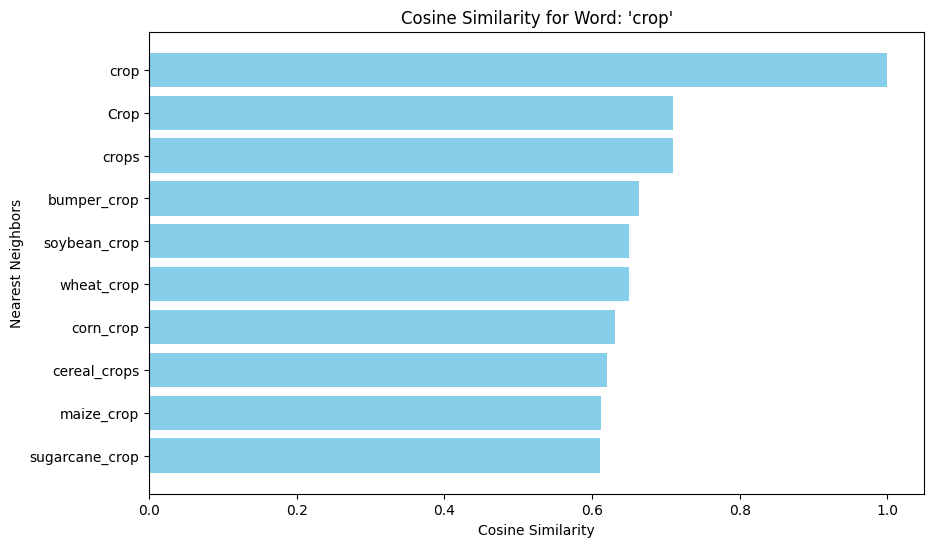


Nearest neighbors for 'season':


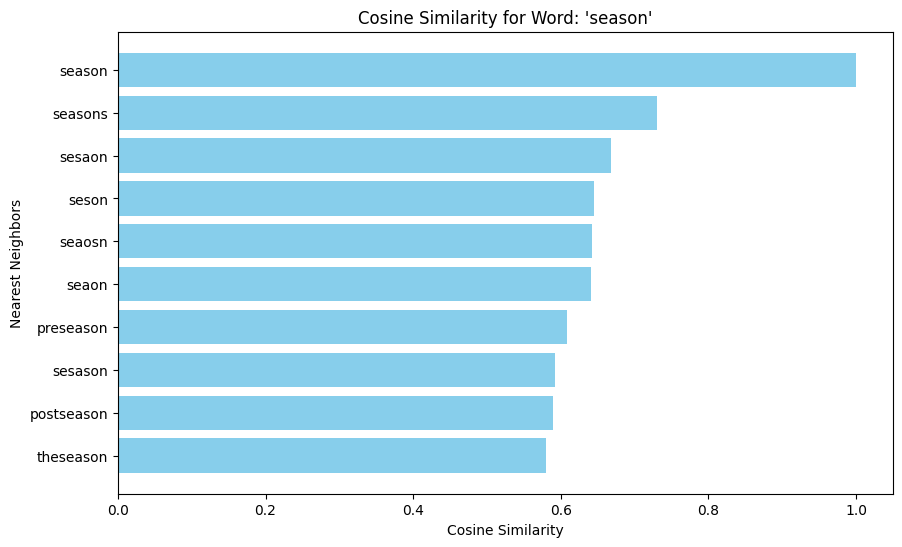


Nearest neighbors for 'area':


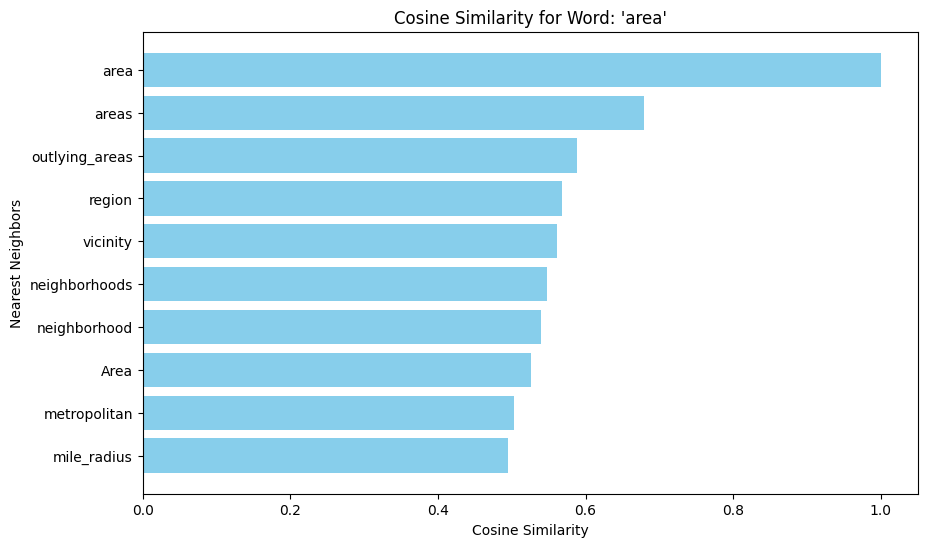


Nearest neighbors for 'farmer':


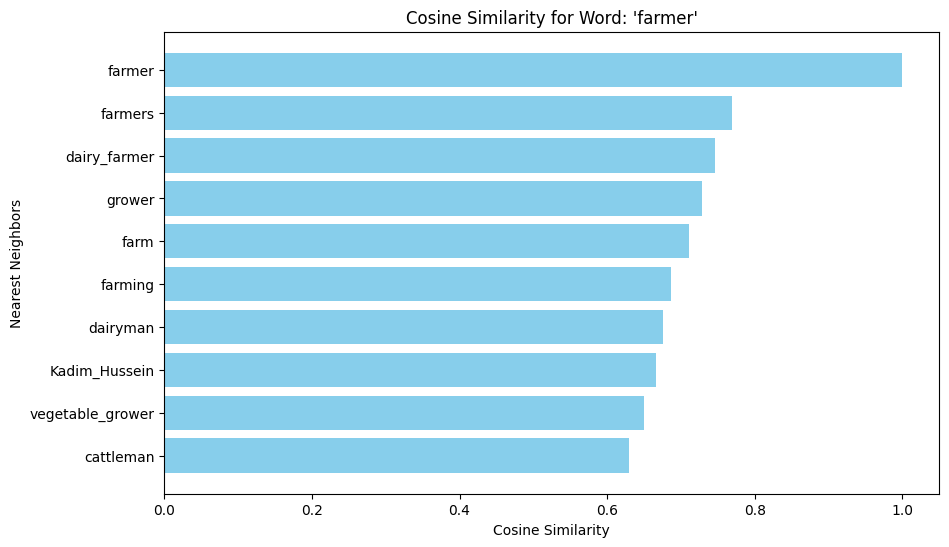


Nearest neighbors for 'agriculture':


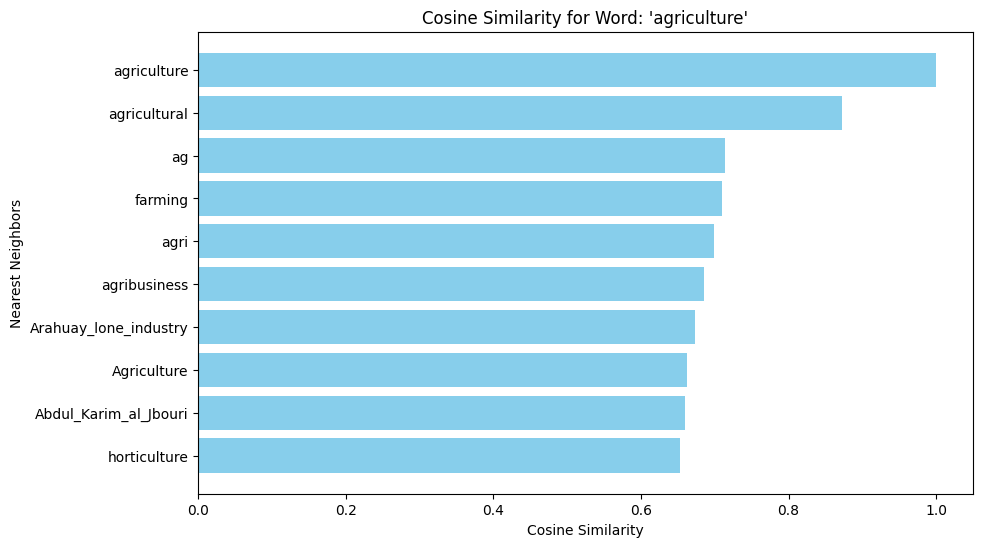


Dot Product Similarity metrics

Nearest neighbors for 'crop':


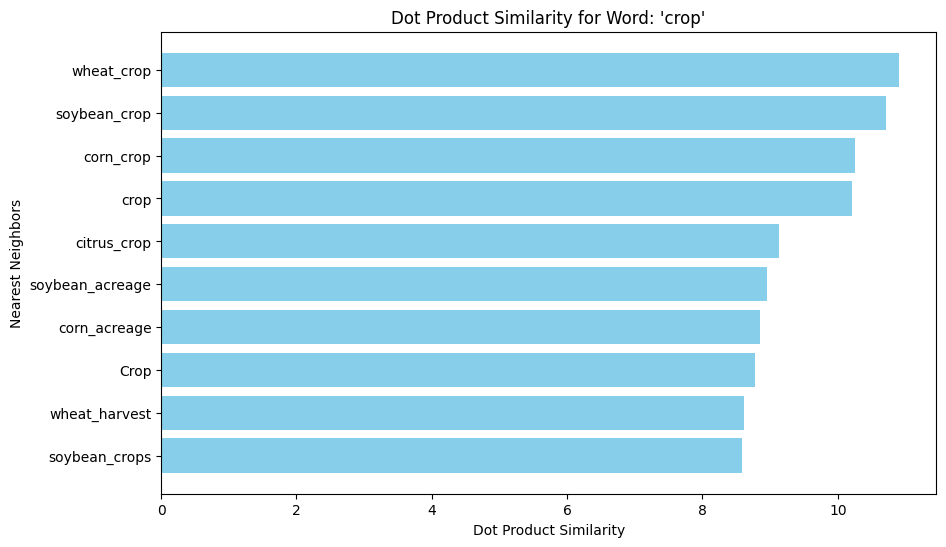


Nearest neighbors for 'season':


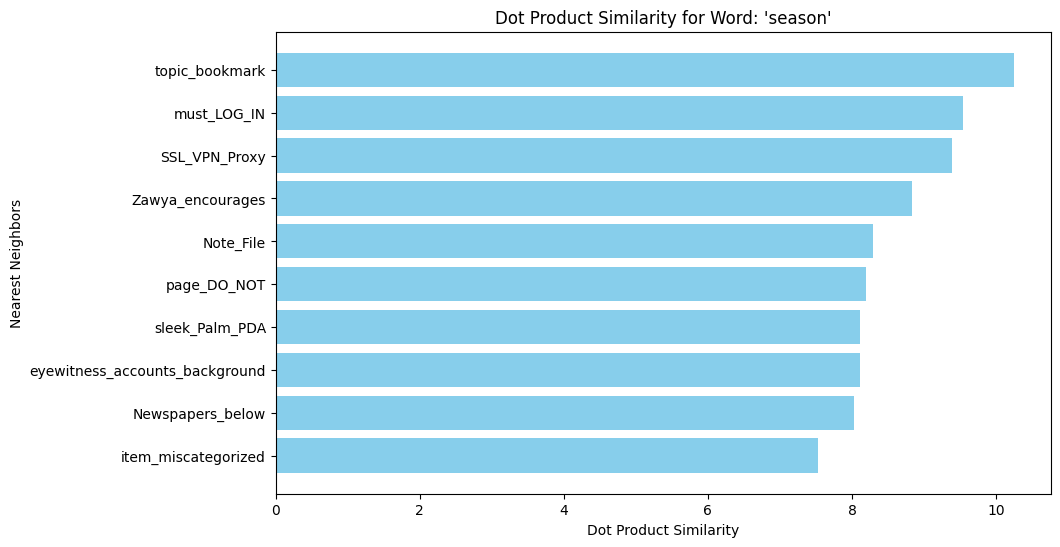


Nearest neighbors for 'area':


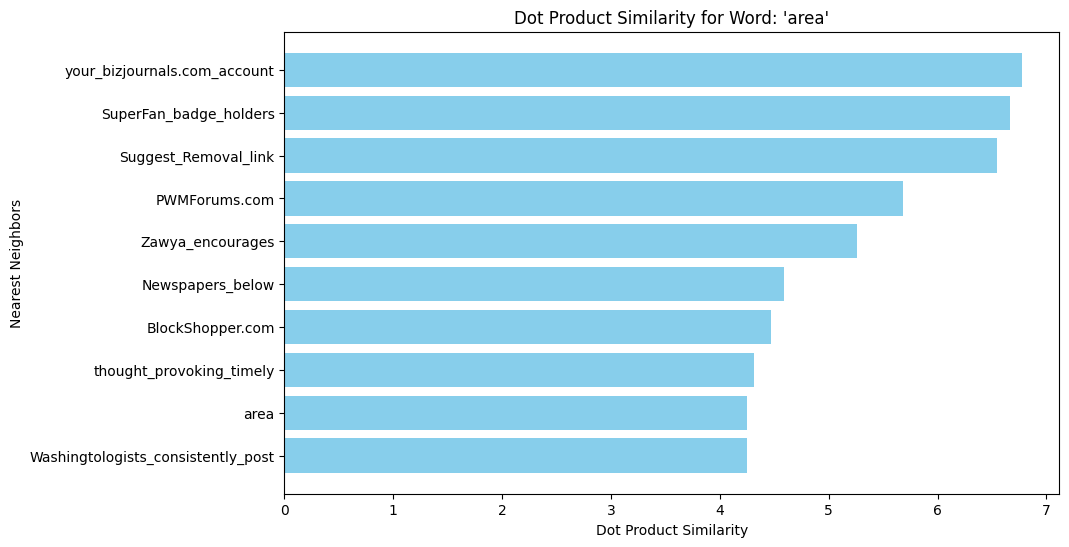


Nearest neighbors for 'farmer':


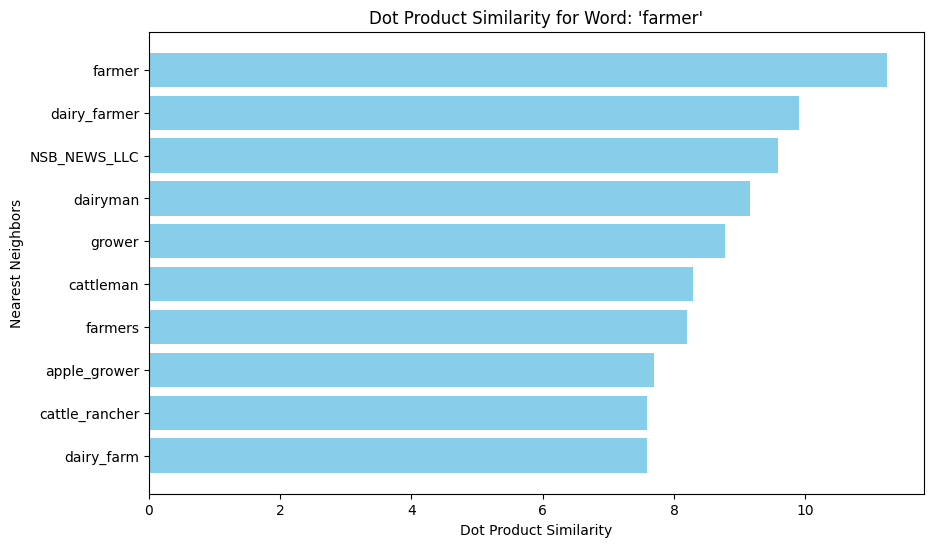


Nearest neighbors for 'agriculture':


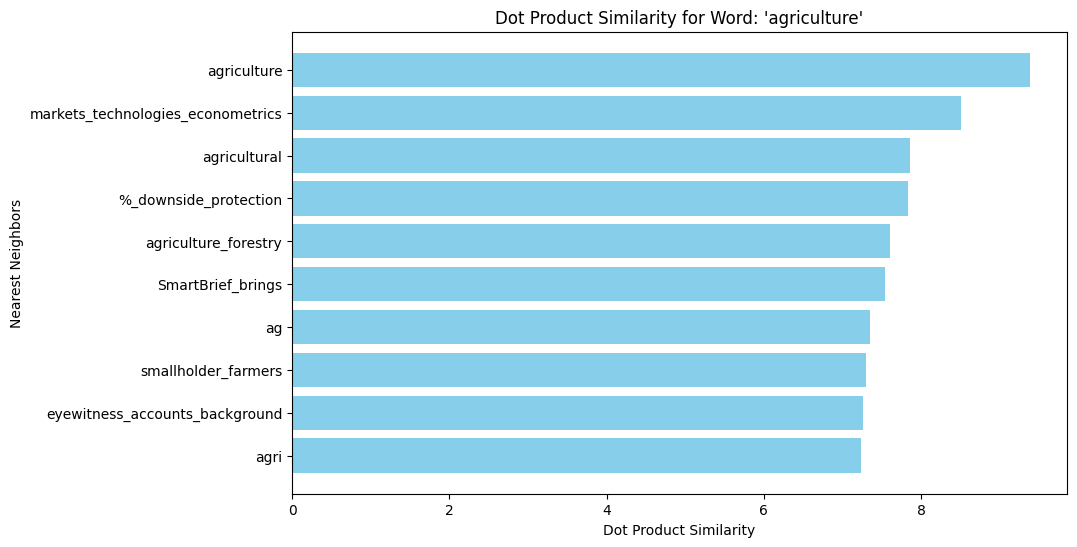

In [243]:
# Cos sim Metric
print("Cosine Similarity metrics")
for word in source_words:
    nearest_neighbors = calculate_nearest_neighbours(word, model, k=10, cosine=True, dot=False)
    print(f"\nNearest neighbors for '{word}':")
    # for similarity, neighbor_word in nearest_neighbors:
    #     print(f"{neighbor_word}: {similarity}")
    
    plot_similarity(word, nearest_neighbors, metric="Cosine")

# Dot sim metric
print("\nDot Product Similarity metrics")
for word in source_words:
    nearest_neighbors = calculate_nearest_neighbours(word, model, k=10, cosine=False, dot=True)
    print(f"\nNearest neighbors for '{word}':")
    # for similarity, neighbor_word in nearest_neighbors:
    #     print(f"{neighbor_word}: {similarity}")
    
    plot_similarity(word, nearest_neighbors, metric="Dot Product")

<a name="section-taskB"></a><h2 style="color:rgb(0,120,170)">Task B: Document Classification with WE (15 points)</h2>


This task follows the same instruction for document classification as provided in Assignment 1. You are indeed free to reuse any part of your code in Assignment 1 for this task. In Assignment 1, the representation of each document was created using a bag of words representation followed by dimensionality reduction. In this task, the document representations are created from the pre-trained word embeddings.

**Map word embeddings to dictionary words (5 points).** For every word in the dictionary (as discussed and created in Assignment 1), fetch the corresponding word embedding from the pre-trained model. If no embedding is found, initialize the corresponding word embedding randomly.

**Document embedding as the average of word embeddings (5 points).** Using the word embeddings, the representation of each document is defined as the *mean of the vectors of each document's words*. In particular, given the document $d$, consisting of words $\left[ v_1, v_2, ..., v_{|d|} \right]$, the document representation $\mathbf{e}_d$ is defined as:

$\mathbf{e}_d = \frac{1}{|d|}\sum_{i=1}^{|d|}{\mathbf{e}_{v_i}}$

where $\mathbf{e}_{v}$ is the vector of the word $v$, and $|d|$ is the length of the document.

**Classification and evaluation (5 points)** Using these new document representations, apply <ins>three classification algorithms</ins> and report the evaluation results (based on accuracy metric) on the test set.



<a name="section-taskC"></a><h2 style="color:rgb(0,120,170)">Task C: Classification with sent2vec Document Embeddings (2 extra point)</h2>


Sent2vec [1] suggests another unsupervised approach to creating document embeddings from the underlying word embeddings. First, using the provided code in the paper, train a sendtvec model on the training set to create document embeddings. Then, repeat Task B while using the document embeddings provided by sent2vec. Similar to Task 2, conduct the classification experiments and report evaluation results.

[1] M. Pagliardini, P. Gupta, and M. Jaggi. Unsupervised Learning of Sentence Embeddings using Compositional n-Gram Features. In Proceedings of the conference of the North American Chapter of the Association for Computational Linguistics (NAACL), 2018.
